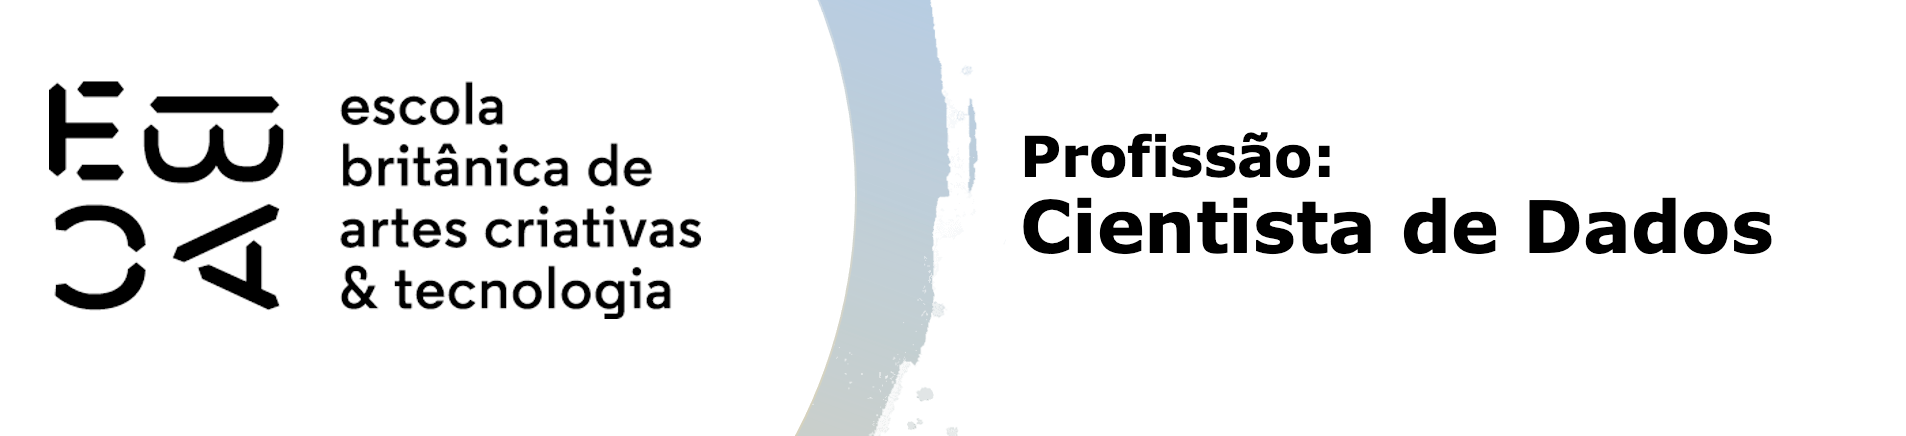

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np


df = pd.read_feather('credit_scoring.ftr')
df.shape
df


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
df = df.drop('index', axis=1)
df.tail()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
749995,2016-03-01,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True
749999,2016-03-01,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,4460.69,False


In [3]:
# Converter 'data_ref' para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Separar os três últimos meses para validação *out of time*
last_three_months = df['data_ref'].max() - pd.DateOffset(months=3)
oot_df = df[df['data_ref'] > last_three_months]
train_df = df[df['data_ref'] < last_three_months]

In [4]:
df = oot_df
df

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
# Número total de linhas
total_rows = len(oot_df)

# Número de linhas para cada mês
monthly_counts = oot_df['data_ref'].value_counts().sort_index()

total_rows, monthly_counts

(150000,
 data_ref
 2016-01-01    50000
 2016-02-01    50000
 2016-03-01    50000
 Name: count, dtype: int64)

In [6]:
# Descrição básica das variáveis quantitativas
quantitative_vars = oot_df.select_dtypes(include=['float64', 'int64'])
quantitative_description = quantitative_vars.describe()

# Descrição básica das variáveis qualitativas
qualitative_vars = oot_df.select_dtypes(include=['object'])
qualitative_description = {col: oot_df[col].value_counts() for col in qualitative_vars.columns}

quantitative_description, qualitative_description


(          qtd_filhos          idade  tempo_emprego  qt_pessoas_residencia  \
 count  150000.000000  150000.000000  124918.000000          150000.000000   
 mean        0.433413      43.829547       7.750898               2.212720   
 std         0.737417      11.226707       6.682998               0.902114   
 min         0.000000      22.000000       0.117808               1.000000   
 25%         0.000000      34.000000       3.071233               2.000000   
 50%         0.000000      43.000000       6.038356               2.000000   
 75%         1.000000      53.000000      10.183562               3.000000   
 max        14.000000      68.000000      42.906849              15.000000   
 
                renda  
 count  150000.000000  
 mean     7301.344809  
 std     20778.675831  
 min       107.670000  
 25%      1598.627500  
 50%      2952.380000  
 75%      5858.200000  
 max    732561.260000  ,
 {'sexo': sexo
  F    100775
  M     49225
  Name: count, dtype: int64,
  'poss

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

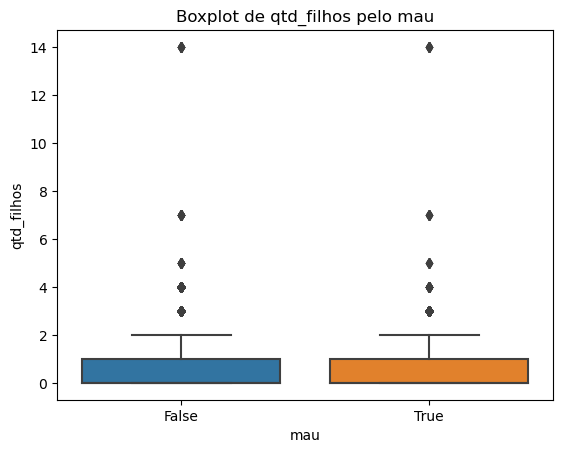

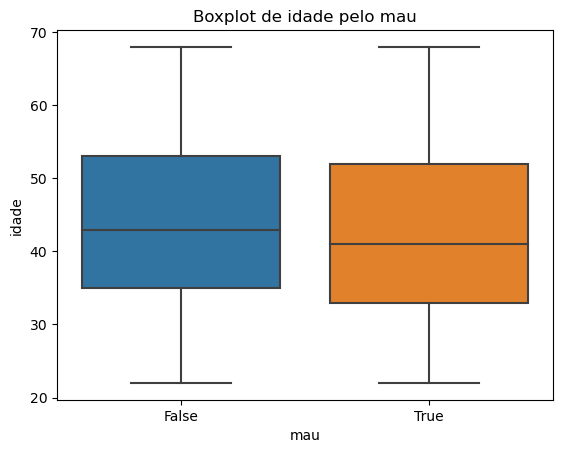

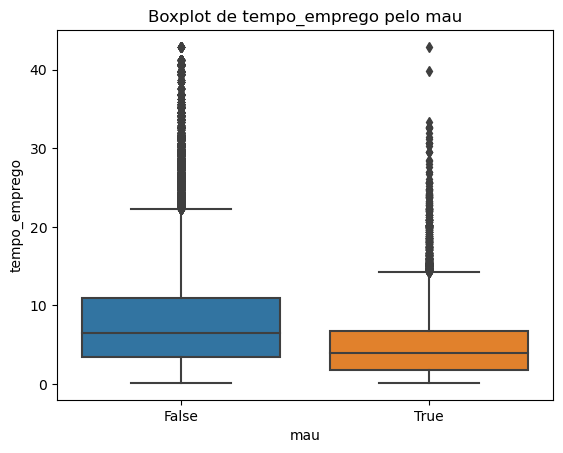

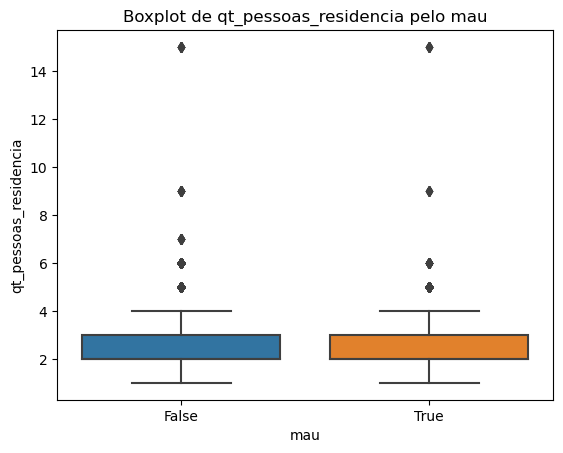

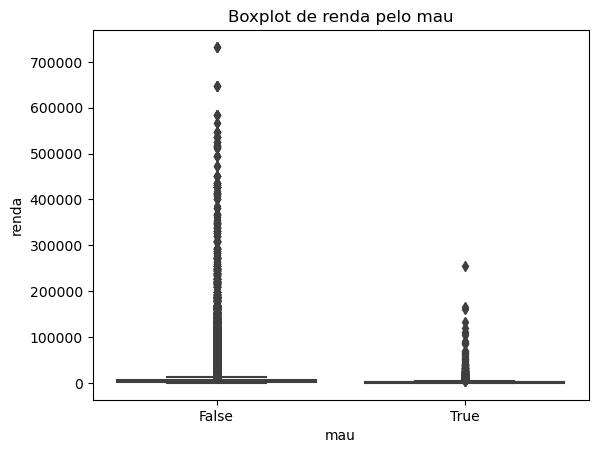

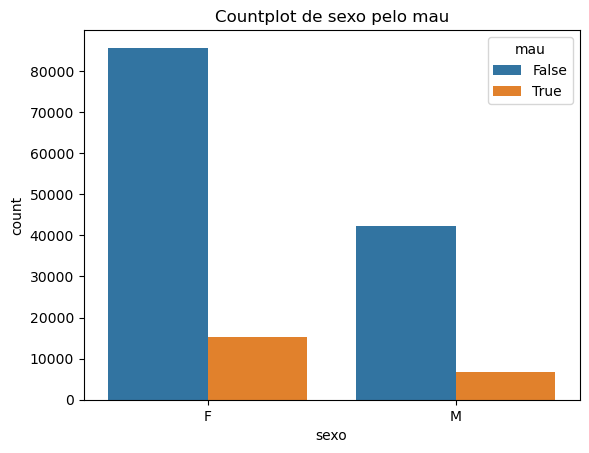

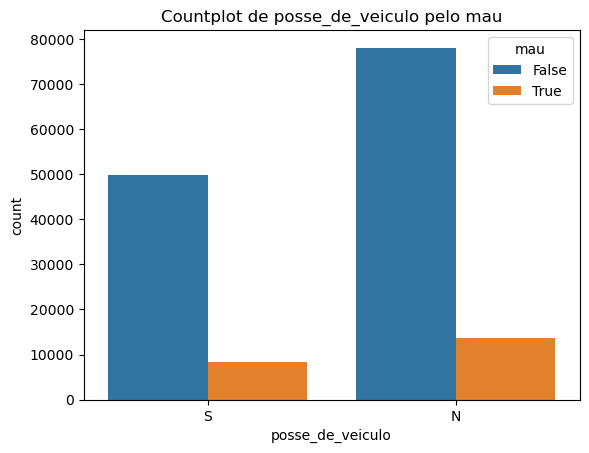

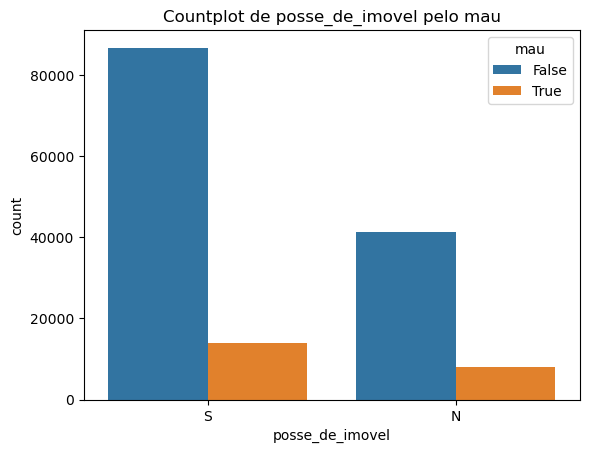

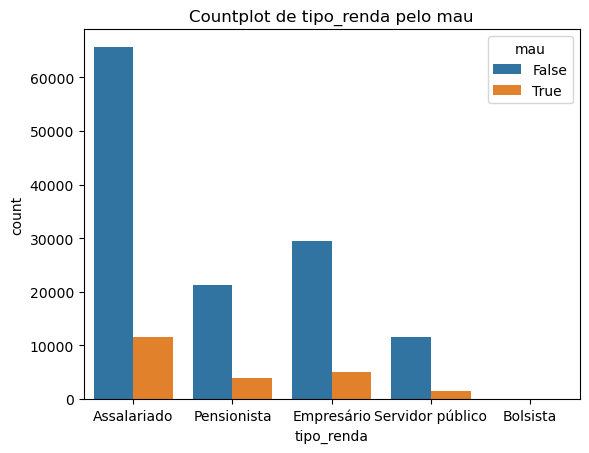

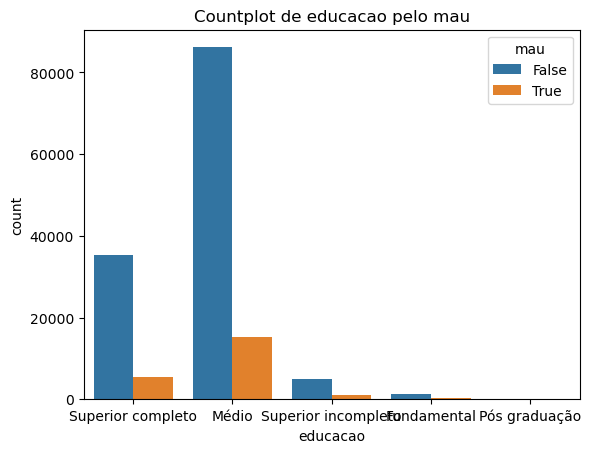

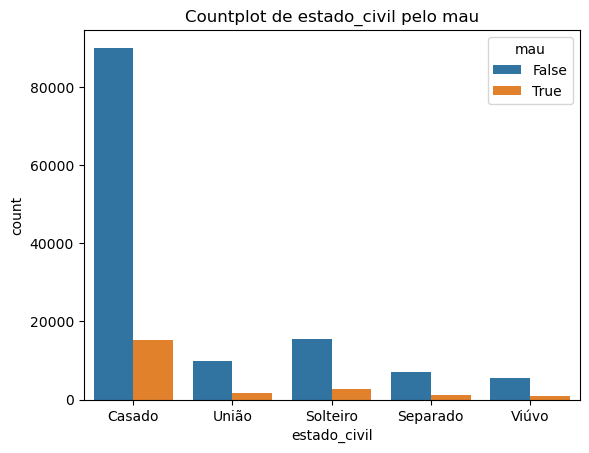

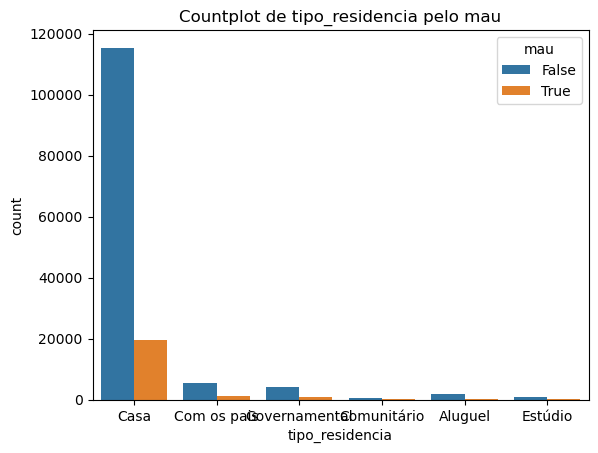

In [7]:
# Visualizações bivariadas
for col in quantitative_vars.columns:
    sns.boxplot(data=df, x='mau', y=col)
    plt.title(f'Boxplot de {col} pelo mau')
    plt.show()

# Para variáveis qualitativas vs. 'mau'
for col in qualitative_vars.columns:
    if col != 'data_ref' and col != 'index':
        sns.countplot(data=df, x=col, hue='mau')
        plt.title(f'Countplot de {col} pelo mau')
        plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 600000 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               150000 non-null  datetime64[ns]
 1   sexo                   150000 non-null  object        
 2   posse_de_veiculo       150000 non-null  object        
 3   posse_de_imovel        150000 non-null  object        
 4   qtd_filhos             150000 non-null  int64         
 5   tipo_renda             150000 non-null  object        
 6   educacao               150000 non-null  object        
 7   estado_civil           150000 non-null  object        
 8   tipo_residencia        150000 non-null  object        
 9   idade                  150000 non-null  int64         
 10  tempo_emprego          124918 non-null  float64       
 11  qt_pessoas_residencia  150000 non-null  float64       
 12  renda                  150000 non-null  floa

In [9]:
# Tratamento de valores missing
df = df.fillna({
    'tempo_emprego': df['tempo_emprego'].median()
})

# Exemplo de tratamento de outliers para uma variável quantitativa
df = df[(np.abs(stats.zscore(df['tempo_emprego'].fillna(df['tempo_emprego'].median()))) < 3)]


In [10]:
# Exemplos de tratamento de zeros estruturais
df['qtd_filhos'] = df['qtd_filhos'].replace(0, df['qtd_filhos'].mode()[0])


In [11]:
df['educacao'].value_counts()

educacao
Médio                  98777
Superior completo      40195
Superior incompleto     5849
Fundamental             1666
Pós graduação            161
Name: count, dtype: int64

In [12]:
for column in df.columns:
    print(f"{column}: {df[column].value_counts().sort_values(ascending=False)}")

data_ref: data_ref
2016-02-01    48900
2016-03-01    48878
2016-01-01    48870
Name: count, dtype: int64
sexo: sexo
F    97751
M    48897
Name: count, dtype: int64
posse_de_veiculo: posse_de_veiculo
N    88939
S    57709
Name: count, dtype: int64
posse_de_imovel: posse_de_imovel
S    98478
N    48170
Name: count, dtype: int64
qtd_filhos: qtd_filhos
0     100338
1      30397
2      13941
3       1709
4        211
7         19
5         18
14        15
Name: count, dtype: int64
tipo_renda: tipo_renda
Assalariado         74903
Empresário          34173
Pensionista         25138
Servidor público    12364
Bolsista               70
Name: count, dtype: int64
educacao: educacao
Médio                  98777
Superior completo      40195
Superior incompleto     5849
Fundamental             1666
Pós graduação            161
Name: count, dtype: int64
estado_civil: estado_civil
Casado      103313
Solteiro     17757
União        11327
Separado      8147
Viúvo         6104
Name: count, dtype: int64
ti

In [13]:
# Agrupamento de categorias menos frequentes
df['educacao'] = df['educacao'].replace({
    'Superior incompleto': 'Superior',
    
})


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [14]:
# Preparação dos dados
features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 
             'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 
             'qt_pessoas_residencia', 'renda']
X = pd.get_dummies(df[features], drop_first=True)
y = df['mau']

# Dividir dados para treinamento e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

# Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

# Métricas
accuracy = accuracy_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
conf_matrix = confusion_matrix(y_valid, y_pred)

# Cálculo de KS e Gini
fpr, tpr, _ = roc_curve(y_valid, model.predict_proba(X_valid)[:, 1])
ks = max(tpr - fpr)
gini = 2 * roc_auc - 1



C:\Users\Xam_j\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# Exibir os resultados
print(f'Com uma acurácia de {(100*accuracy):.2f} %, o modelo está acertando a maioria das classificações, o que indica um bom desempenho geral na base de validação.')

print(f'Um AUC de {roc_auc:.4f} indica que o modelo tem uma boa capacidade de discriminação, sendo capaz de separar as classes com uma probabilidade de {(100*roc_auc):.1f}% para um classificador aleatório.')

print("\nMatriz de Confusão:")
print(conf_matrix)
print(f"\nKS: {ks:.4f}")
print(f"Gini: {gini:.4f}")

# Explicações
print("\nExplicações:")
print("Acurácia (Accuracy): Proporção de previsões corretas em relação ao total de previsões.")
print(f"   Valor: {accuracy:.4f}")

print("\nAUC-ROC (Área sob a Curva ROC): Mede a capacidade do modelo de distinguir entre as classes.")
print(f"   Valor: {roc_auc:.4f}")

print("\nMatriz de Confusão:")
print("   [TN, FP]")
print("   [FN, TP]")
print("   TN: Verdadeiros Negativos (clientes que não são inadimplentes e foram corretamente classificados).")
print("   FP: Falsos Positivos (clientes que não são inadimplentes mas foram classificados como inadimplentes).")
print("   FN: Falsos Negativos (clientes que são inadimplentes mas foram classificados como não inadimplentes).")
print("   TP: Verdadeiros Positivos (clientes que são inadimplentes e foram corretamente classificados como inadimplentes).")

print("\nKS (Kolmogorov-Smirnov): Mede a maior diferença entre as curvas de distribuição cumulativa das duas classes.")
print(f"   Valor: {ks:.4f}")

print("\nÍndice de Gini: Derivado do AUC-ROC, mede a desigualdade na distribuição das probabilidades preditivas.")
print(f"   Valor: {gini:.4f}")

Com uma acurácia de 85.11 %, o modelo está acertando a maioria das classificações, o que indica um bom desempenho geral na base de validação.
Um AUC de 0.7278 indica que o modelo tem uma boa capacidade de discriminação, sendo capaz de separar as classes com uma probabilidade de 72.8% para um classificador aleatório.

Matriz de Confusão:
[[37445     0]
 [ 6550     0]]

KS: 0.3355
Gini: 0.4556

Explicações:
Acurácia (Accuracy): Proporção de previsões corretas em relação ao total de previsões.
   Valor: 0.8511

AUC-ROC (Área sob a Curva ROC): Mede a capacidade do modelo de distinguir entre as classes.
   Valor: 0.7278

Matriz de Confusão:
   [TN, FP]
   [FN, TP]
   TN: Verdadeiros Negativos (clientes que não são inadimplentes e foram corretamente classificados).
   FP: Falsos Positivos (clientes que não são inadimplentes mas foram classificados como inadimplentes).
   FN: Falsos Negativos (clientes que são inadimplentes mas foram classificados como não inadimplentes).
   TP: Verdadeiros P

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Definir colunas categóricas e numéricas
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
numeric_features = ['tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Definir transformadores para cada tipo de dado
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   # Substitui valores nulos pela média
    ('scaler', StandardScaler())                  # Normaliza variáveis numéricas
])

# Definir o pré-processamento para cada coluna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [17]:
# Obter os nomes das colunas após a codificação one-hot
df_processed = preprocessor.fit_transform(df)
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# Transformar o array de volta em um DataFrame
df_processed = pd.DataFrame(df_processed, columns=all_feature_names)


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [18]:
from scipy import stats

def remove_outliers(df, numeric_features, threshold=3.0):
    z_scores = stats.zscore(df[numeric_features].dropna())
    abs_z_scores = np.abs(z_scores)
    filter_outliers = (abs_z_scores < threshold).all(axis=1)
    return df[filter_outliers]


In [19]:
# Remover outliers antes do pré-processamento
df_cleaned = remove_outliers(df, numeric_features)

# Aplicar o pipeline de pré-processamento ao DataFrame limpo
df_processed = preprocessor.fit_transform(df_cleaned)


In [20]:
# Obter os nomes das colunas após a codificação one-hot
df_processed = preprocessor.fit_transform(df)
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# Transformar o array de volta em um DataFrame
df_processed = pd.DataFrame(df_processed, columns=all_feature_names)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

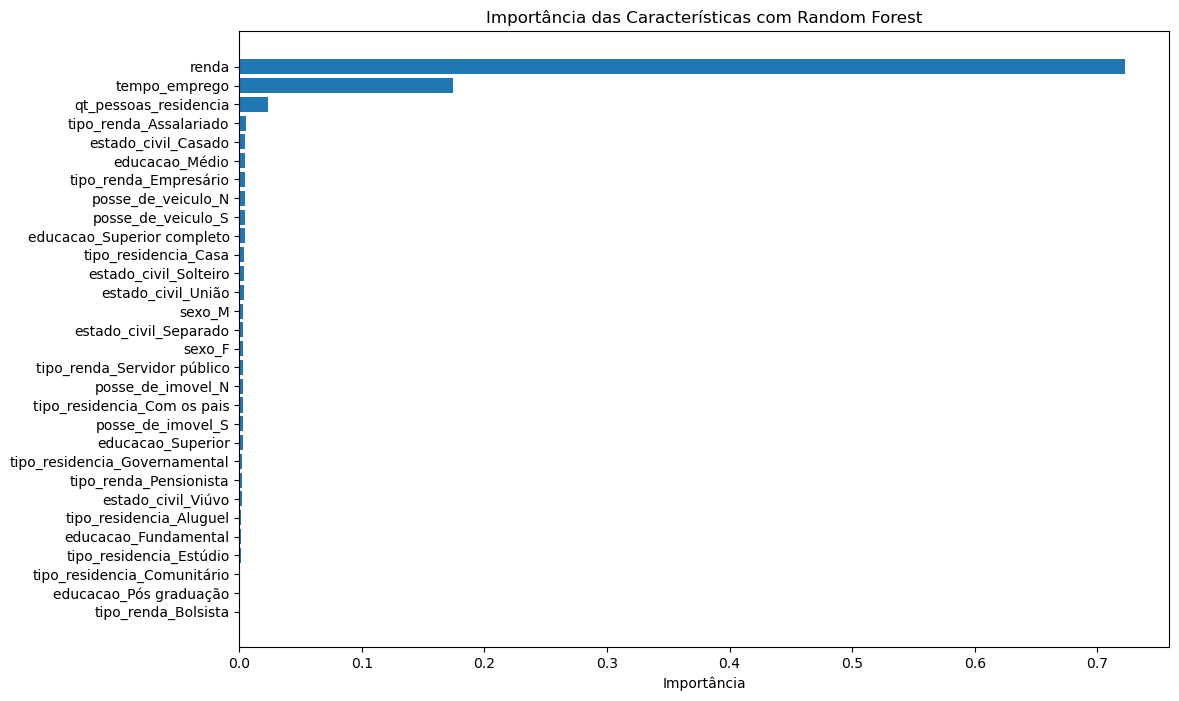

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Aplicar o pipeline de pré-processamento ao DataFrame limpo
X_processed = preprocessor.fit_transform(df_cleaned)
y = df_cleaned['mau']  # Ajuste isso se a variável alvo for diferente

# Treinar o modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_processed, y)

# Obter importâncias das características
importances = model.feature_importances_

# Obter nomes das características após a codificação one-hot
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# Criar DataFrame com importâncias das características
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotar a importância das características
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância')
plt.title('Importância das Características com Random Forest')
plt.gca().invert_yaxis()  # Inverter o eixo y para que as características mais importantes fiquem no topo
plt.show()

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

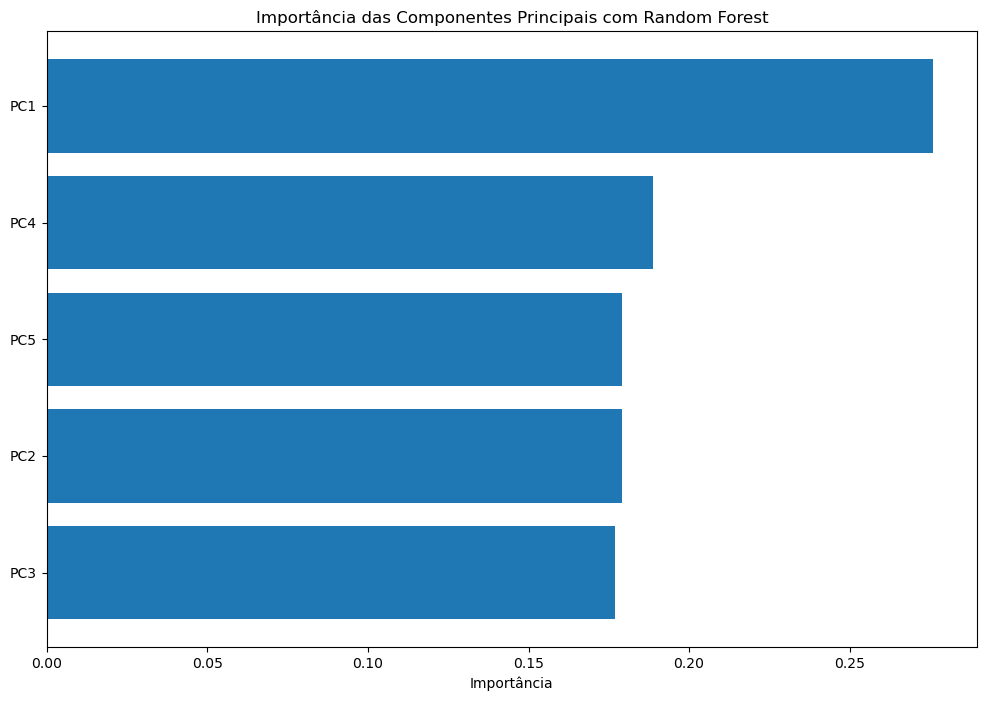

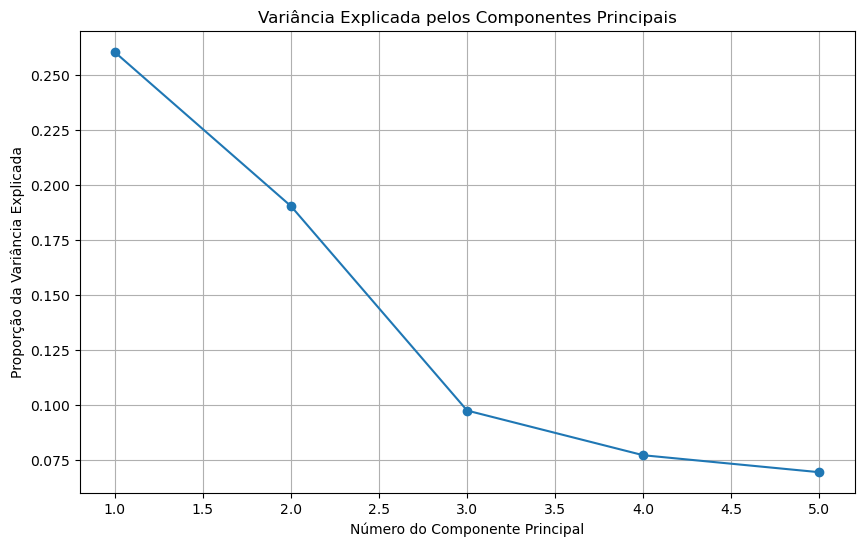

In [22]:
from sklearn.decomposition import PCA

# Pipeline de pré-processamento + PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5))  # Reduzir para 5 componentes principais
])

# Aplicar o pipeline ao DataFrame limpo
X_processed_pca = pipeline.fit_transform(df_cleaned)
y = df_cleaned['mau']  # Ajuste isso se a variável alvo for diferente

# Treinar o modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_processed_pca, y)

# Obter importâncias das características após PCA
importances = model.feature_importances_

# Obter o nome das componentes principais
pca = pipeline.named_steps['pca']
components = pca.components_

# Criar DataFrame com importâncias das características
# Nota: Após PCA, as características são componentes principais, então a interpretação é diferente.
feature_importance_df = pd.DataFrame({
    'Feature': [f'PC{i+1}' for i in range(5)],  # Nomes das componentes principais
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotar a importância das características
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância')
plt.title('Importância das Componentes Principais com Random Forest')
plt.gca().invert_yaxis()  # Inverter o eixo y para que as características mais importantes fiquem no topo
plt.show()

# Visualizar a variância explicada pelos componentes principais
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), explained_variance, marker='o')
plt.xlabel('Número do Componente Principal')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Variância Explicada pelos Componentes Principais')
plt.grid(True)
plt.show()

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [23]:
# Tornando as variaveis categoricas em dummies
df_encoded = pd.get_dummies(df, columns=[
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
    'educacao', 'estado_civil', 'tipo_residencia'
])

df_encoded

,data_ref,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_F,sexo_M,posse_de_veiculo_N,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
600000,2016-01-01,2,38,7.383562,4.0,2969.49,True,True,False,False,...,False,False,False,False,False,True,False,False,False,False
600001,2016-01-01,0,55,8.471233,2.0,6278.37,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
600002,2016-01-01,1,39,8.884932,3.0,14010.18,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
600003,2016-01-01,1,31,1.794521,3.0,2875.81,False,True,False,True,...,False,False,True,False,False,False,True,False,False,False
600004,2016-01-01,0,27,7.019178,2.0,2737.19,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,0,48,3.038356,2.0,2109.99,False,False,True,True,...,False,False,False,False,False,True,False,False,False,False
749996,2016-03-01,0,65,6.038356,1.0,1389.39,False,True,False,True,...,False,True,False,False,False,True,False,False,False,False
749997,2016-03-01,2,43,10.375342,4.0,649.06,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False
749998,2016-03-01,0,56,13.780822,1.0,4216.72,True,True,False,True,...,False,False,False,True,False,True,False,False,False,False


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [25]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
df_encoded = pd.get_dummies(data, columns=[
    'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
    'educacao', 'estado_civil', 'tipo_residencia'
])
print('Conjunto de dados para modelagem (treino e teste): ' + str(df_encoded.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(df_encoded.shape))


Conjunto de dados para modelagem (treino e teste): (712500, 35)
Conjunto de dados não usados no treino/teste, apenas como validação: (712500, 35)


In [26]:
from pycaret.classification import *

In [27]:
df_encoded.dtypes

data_ref                         datetime64[ns]
index                                     int64
qtd_filhos                                int64
idade                                     int64
tempo_emprego                           float64
qt_pessoas_residencia                   float64
renda                                   float64
mau                                        bool
sexo_F                                     bool
sexo_M                                     bool
posse_de_veiculo_N                         bool
posse_de_veiculo_S                         bool
posse_de_imovel_N                          bool
posse_de_imovel_S                          bool
tipo_renda_Assalariado                     bool
tipo_renda_Bolsista                        bool
tipo_renda_Empresário                      bool
tipo_renda_Pensionista                     bool
tipo_renda_Servidor público                bool
educacao_Fundamental                       bool
educacao_Médio                          

In [28]:
df_encoded.corr()

,data_ref,index,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_F,sexo_M,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
data_ref,1.000000,-0.001404,-0.000881,0.000071,-0.001865,-0.001042,-0.050909,0.070286,-0.001263,0.001263,...,-0.001922,0.003134,0.000835,-0.002068,0.002318,-0.000638,-0.001401,-0.001781,0.000267,0.001750
index,-0.001404,1.000000,0.031063,-0.047282,-0.034768,0.032618,-0.011412,0.009143,-0.027405,0.027405,...,-0.018899,0.014602,-0.008922,-0.033310,-0.012791,-0.021343,0.022332,0.008310,0.013337,0.009507
qtd_filhos,-0.000881,0.031063,1.000000,-0.370218,-0.075568,0.890370,-0.042224,0.007160,-0.115424,0.115424,...,-0.017486,-0.126528,-0.000290,-0.101895,0.001382,-0.030430,0.035882,0.001856,0.027061,-0.004508
idade,0.000071,-0.047282,-0.370218,1.000000,0.330207,-0.341194,0.102166,-0.027774,0.216225,-0.216225,...,0.052249,-0.067132,-0.057045,0.223711,-0.067861,0.155233,-0.186921,-0.018810,-0.008853,0.009221
tempo_emprego,-0.001865,-0.034768,-0.075568,0.330207,1.000000,-0.066648,0.498228,-0.132114,0.137625,-0.137625,...,0.020352,-0.020316,-0.020247,0.035215,-0.031312,0.055542,-0.073585,-0.026035,0.013144,0.020041
qt_pessoas_residencia,-0.001042,0.032618,0.890370,-0.341194,-0.066648,1.000000,-0.047981,0.004114,-0.153215,0.153215,...,-0.225797,-0.422349,0.069765,-0.264323,-0.010127,-0.015367,0.024758,0.002737,0.024688,-0.008890
renda,-0.050909,-0.011412,-0.042224,0.102166,0.498228,-0.047981,1.000000,-0.068370,0.071288,-0.071288,...,0.013409,0.025507,-0.003979,0.003971,-0.012163,0.020546,-0.026226,-0.004293,-0.002495,0.006438
mau,0.070286,0.009143,0.007160,-0.027774,-0.132114,0.004114,-0.068370,1.000000,0.012631,-0.012631,...,0.003074,0.003942,0.006026,-0.002674,0.005581,-0.012029,0.012856,0.001747,-0.003911,0.003116
sexo_F,-0.001263,-0.027405,-0.115424,0.216225,0.137625,-0.153215,0.071288,0.012631,1.000000,-1.000000,...,0.062409,0.034564,0.024077,0.139258,-0.048626,0.062071,-0.054117,-0.019598,-0.053503,0.022563
sexo_M,0.001263,0.027405,0.115424,-0.216225,-0.137625,0.153215,-0.071288,-0.012631,-1.000000,1.000000,...,-0.062409,-0.034564,-0.024077,-0.139258,0.048626,-0.062071,0.054117,0.019598,0.053503,-0.022563


In [29]:
data = df_encoded

In [30]:
data.mau.value_counts(normalize=True)

mau
False    0.921691
True     0.078309
Name: proportion, dtype: float64

In [31]:
exp_aula4 = setup(data = data, target = 'mau', experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True)



,Description,Value
0,Session id,2825
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 35)"
4,Transformed data shape,"(1133137, 37)"
5,Transformed train set shape,"(919386, 37)"
6,Transformed test set shape,"(213751, 37)"
7,Numeric features,6
8,Date features,1
9,Rows with missing values,16.8%


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits

In [33]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [34]:
from pycaret.classification import *
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [35]:
df = df.drop('index', axis=1)

# Converter 'data_ref' para datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Separar os três últimos meses para validação *out of time*
last_three_months = df['data_ref'].max() - pd.DateOffset(months=3)
dataset = df[df['data_ref'] > last_three_months]
train_df = df[df['data_ref'] < last_three_months]

dataset['data_ref'].unique()


<DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Dividir o DataFrame em Variáveis Independentes
X = data.drop(columns=['data_ref', 'renda'])
y = data['renda']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Definir o Imputer para lidar com valores faltantes
imputer = SimpleImputer(strategy='mean')  # Substitui valores faltantes pela média

# Define o PCA para redução de dimensionalidade linear
pca = PCA(n_components=5)

# Define o Standard Scaler para normalizar os dados
scaler = StandardScaler()

# Define a Regressão Linear
linear_reg = LinearRegression()

# "Fitando" e aplicando o Imputer nos dados de treino
imputer.fit(X_train)
X_train = imputer.transform(X_train)

# "Fitando" e aplicando o Standard Scaler nos dados de treino
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# "Fitando" e aplicando o PCA nos dados de treino
pca.fit(X_train)
X_train = pca.transform(X_train)

# "Fitando" e predizendo uma regressão linear nos dados de treino
linear_reg.fit(X_train, y_train)

# Predizendo nos dados de treino
y_train_pred = linear_reg.predict(X_train)

# Aplicando o Imputer, Standard Scaler e PCA nos dados de teste
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

# Predizendo nos dados de teste
y_test_pred = linear_reg.predict(X_test)

print("Previsões no conjunto de treino:\n", y_train_pred)
print("Previsões no conjunto de teste:\n", y_test_pred)


Previsões no conjunto de treino:
 [30305.05395315 21500.73991207 10928.78840069 ... 27057.42656749
 22505.34321998 15668.36879445]
Previsões no conjunto de teste:
 [20142.02514845 17155.98402133 14323.26923667 ... 10665.06157712
 27394.45195563 24738.86723006]


In [37]:
# Criar o Pipeline com os passos definidos
pipe = Pipeline(steps=[
    ("imputer", imputer), 
    ("scaler", scaler), 
    ("pca", pca), 
    ("linear_reg", linear_reg)
])

# Verificar os passos do Pipeline
print(pipe.named_steps)


{'imputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              keep_empty_features=False, missing_values=nan, strategy='mean'), 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'pca': PCA(copy=True, iterated_power='auto', n_components=5, n_oversamples=10,
    power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
    tol=0.0, whiten=False), 'linear_reg': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, positive=False)}


In [38]:
from pycaret.classification import compare_models

# Ordenar os modelos com base na métrica de avaliação 'Accuracy'
best_model = compare_models(fold=10, sort='Accuracy')


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9217,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,3.6400
qda,Quadratic Discriminant Analysis,0.9150,0.6526,0.0084,0.0082,0.0083,0.0004,0.0004,4.7430
ridge,Ridge Classifier,0.9126,0.7612,0.1378,0.3515,0.1979,0.1609,0.1809,3.7350
lda,Linear Discriminant Analysis,0.9126,0.7612,0.1373,0.3515,0.1975,0.1605,0.1806,5.7570
svm,SVM - Linear Kernel,0.9120,0.7740,0.1587,0.3616,0.2196,0.1805,0.1983,4.1470
lr,Logistic Regression,0.9028,0.7776,0.2248,0.3256,0.2659,0.2158,0.2201,5.4380
gbc,Gradient Boosting Classifier,0.8943,0.7732,0.2637,0.3005,0.2809,0.2241,0.2247,61.5860
knn,K Neighbors Classifier,0.8935,0.6390,0.1436,0.2218,0.1743,0.1202,0.1234,86.2670
et,Extra Trees Classifier,0.8935,0.5949,0.1207,0.2010,0.1508,0.0978,0.1014,45.3770
rf,Random Forest Classifier,0.8894,0.6860,0.1426,0.2045,0.1680,0.1108,0.1129,39.7880


In [39]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8866,0.7679,0.2802,0.2777,0.2789,0.2174,0.2174
1,0.8783,0.7723,0.2948,0.2578,0.2750,0.2090,0.2095
2,0.8844,0.7693,0.2789,0.2698,0.2742,0.2115,0.2115
3,0.8880,0.7789,0.2837,0.2844,0.2840,0.2233,0.2233
4,0.8862,0.7718,0.2683,0.2712,0.2697,0.2080,0.2080
5,0.8840,0.7734,0.2829,0.2702,0.2764,0.2134,0.2135
6,0.8896,0.7704,0.2663,0.2826,0.2742,0.2145,0.2146
7,0.8863,0.7663,0.2573,0.2664,0.2618,0.2002,0.2002
8,0.8853,0.7755,0.2837,0.2747,0.2791,0.2168,0.2168


In [40]:
tuned_lightgbm = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8788,0.7702,0.3388,0.2764,0.3045,0.2388,0.2403
1,0.8745,0.7756,0.3636,0.2733,0.3121,0.2446,0.2476
2,0.8803,0.7728,0.3357,0.2798,0.3052,0.2403,0.2415
3,0.8766,0.7777,0.3505,0.2746,0.3080,0.2413,0.2435
4,0.8746,0.7744,0.3523,0.2698,0.3055,0.2379,0.2405
5,0.8727,0.7759,0.3600,0.2676,0.3070,0.2385,0.2417
6,0.8726,0.7681,0.3592,0.2670,0.3063,0.2378,0.2410
7,0.8774,0.7655,0.3326,0.2703,0.2982,0.2319,0.2334
8,0.8779,0.7772,0.3438,0.2757,0.3060,0.2399,0.2417


Fitting 10 folds for each of 10 candidates, totalling 100 fits


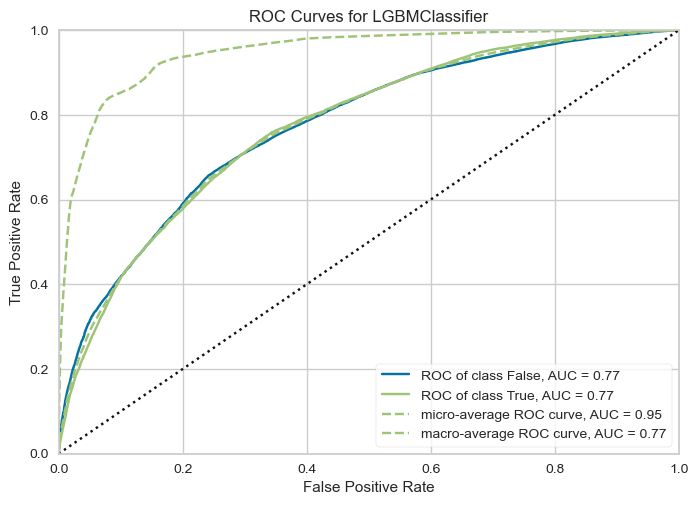

In [41]:
from pycaret.classification import plot_model

# Plotar a Curva ROC para o modelo ajustado
plot_model(tuned_lightgbm, plot='auc')


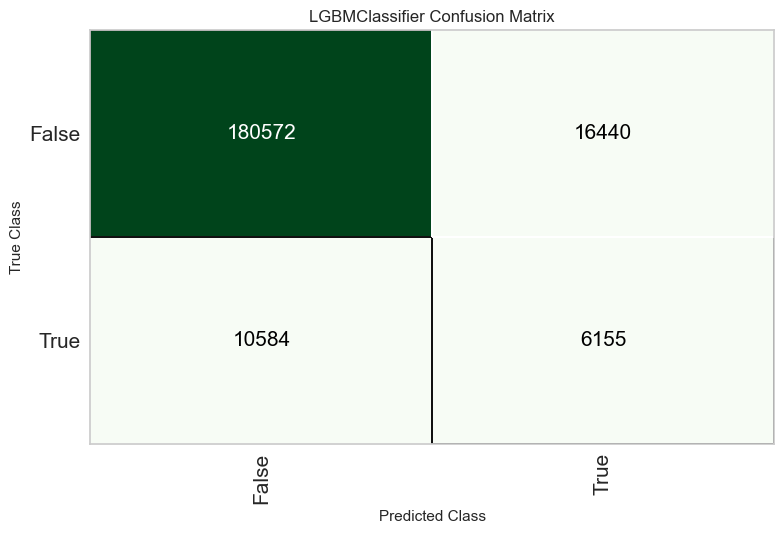

In [42]:
# Plotar a Matriz de Confusão para o modelo ajustado
plot_model(tuned_lightgbm, plot='confusion_matrix')


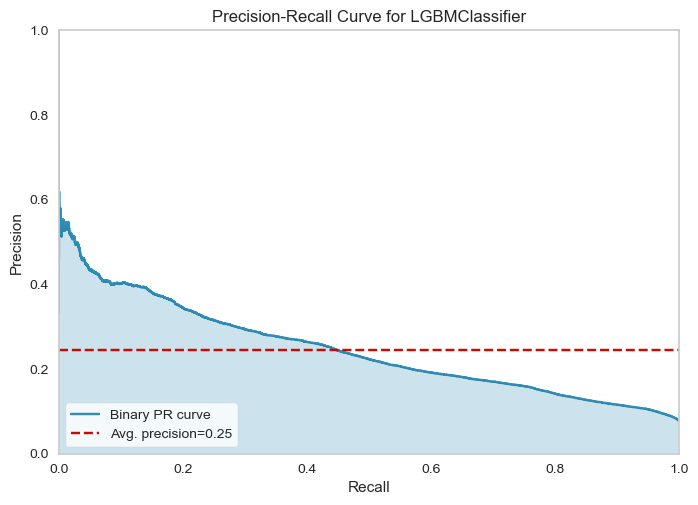

In [43]:
plot_model(tuned_lightgbm, plot = 'pr')

In [44]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…